In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio
!pip install pillow

In [ ]:
import os
import numpy as np
from PIL import Image
import rasterio
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [ ]:
!pip install opencv-python

In [ ]:
from PIL import Image
import os

def convert_image(input_path, output_path):
    with Image.open(input_path) as img:
        img.convert('RGB').save(output_path, format='JPEG')

def convert_directory(input_directory, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for root, dirs, files in os.walk(input_directory):
        for file in files:
            if file.lower().endswith(('.tif', '.tiff')):
                input_path = os.path.join(root, file)
                # Maintain the directory structure
                relative_path = os.path.relpath(input_path, input_directory)
                output_path = os.path.join(output_directory, os.path.splitext(relative_path)[0] + '.jpg')
                output_dir = os.path.dirname(output_path)
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                convert_image(input_path, output_path)

input_directory = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images'
output_directory = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'

convert_directory(input_directory, output_directory)


In [ ]:
!pip install torch torchvision pillow
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.8 MB/s eta 0:00:00


In [ ]:
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os

In [ ]:
data_path = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'
output_path = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_classified'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = ImageFolder(root=data_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# Load pre-trained SE-ResNet model
model = timm.create_model('seresnet50', pretrained=True)
num_classes = len(dataset.classes)  # Number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace the final layer

# Move model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [45]:
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/5, Loss: 0.0917524232204552
Epoch 2/5, Loss: 0.059690683284619205
Epoch 3/5, Loss: 0.07379989269203648
Epoch 4/5, Loss: 0.03746198952395582
Epoch 5/5, Loss: 0.017634194577112794


In [47]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the training set: {100 * correct / total}%')


Accuracy of the model on the training set: 99.9047619047619%


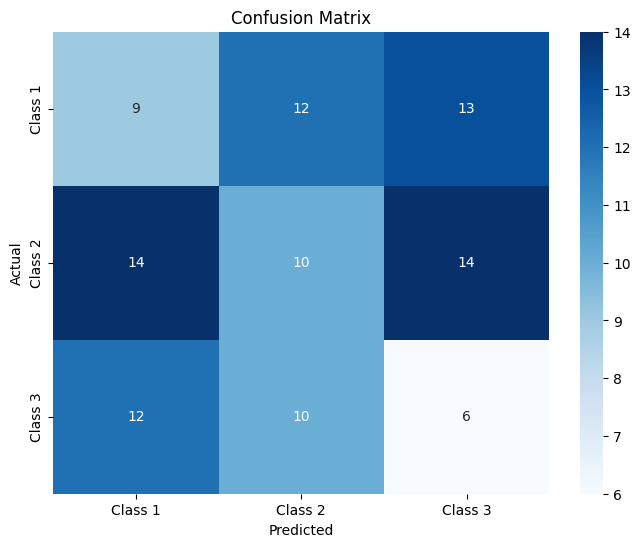

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
all_preds = np.random.randint(0, 3, size=100)
all_labels = np.random.randint(0, 3, size=100)
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [52]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


In [53]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [57]:
from sklearn.metrics import classification_report
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
# Move class_names outside the loop to define it only once
class_names = ['Class 1', 'Class 2', 'Class 3']
# Print unique values in y_true and y_pred to check for unexpected values
print(f'Unique values in y_true: {np.unique(y_true)}')
print(f'Unique values in y_pred: {np.unique(y_pred)}')
print(classification_report(y_true, y_pred, target_names=class_names))

Unique values in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Unique values in y_pred: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


ValueError: Number of classes, 21, does not match size of target_names, 3. Try specifying the labels parameter